# Supervised ML models training

## 1. Introduction

This notebook aims to predict **weld quality** using various **supervised machine learning** methods. 

The notebook includes: 
1. Introduction  

2. Setup  

3. Creating functions:  
- Model definitions  
- Model evaluation    
- Model comparison   
- Model interpretation  
4. Model training :
- Data set with all features (before + after welding)
- Data set without post-welding measurement 
5. Conclusion 


## 2. Setup

In [109]:
# All the import

import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


In [110]:
data_dir = "preprocess_data/"

# Load train/test before PCA 
X_train = pd.read_csv(f"{data_dir}train_processed.csv", sep=",", header=0, index_col=0)
X_test  = pd.read_csv(f"{data_dir}test_processed.csv", sep=",", header=0, index_col=0)
y_train = X_train.pop("yield_strength_mpa") 
y_test  = X_test.pop("yield_strength_mpa")

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (1321, 48), Test shape: (331, 48)


In [111]:
# Filter out NaNs in target
mask_train = y_train.notna()
X_train_without_nan = X_train.loc[mask_train]
y_train_without_nan = y_train.loc[mask_train]

mask_test = y_test.notna()
X_test_without_nan = X_test.loc[mask_test]
y_test_without_nan = y_test.loc[mask_test]

print(X_train_without_nan.shape, X_test_without_nan.shape)
print(y_train_without_nan.isna().sum(), y_test_without_nan.isna().sum()) 

(613, 48) (167, 48)
0 0


## 3. Creating functions

### a. Model definitions

In [112]:
def get_models():
    """Return a dictionary of regression models to evaluate."""
   
    models = {
        'XGBoost': XGBRegressor(
            n_estimators=500, learning_rate=0.05, max_depth=6, subsample=0.8,
            colsample_bytree=0.8, random_state=42, n_jobs=-1, verbosity=0
        ),
        'LightGBM': LGBMRegressor(
            n_estimators=500, learning_rate=0.05, max_depth=6, num_leaves=31,
            subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1, verbose=-1
        ),
        'Random Forest': RandomForestRegressor(
            n_estimators=500, max_depth=None, min_samples_split=5, min_samples_leaf=2,
            max_features='sqrt', random_state=42, n_jobs=-1, bootstrap=True
        ),
        'Gradient Boosting': GradientBoostingRegressor(
            n_estimators=500, learning_rate=0.05, max_depth=5, subsample=0.8,
            min_samples_split=5, min_samples_leaf=2, random_state=42
        )
    }
    return models

### b. Model Evaluation

In [113]:
def evaluate_model(model, X_train, X_test, y_train, y_test, name):
    """
    Train and evaluate a single model.

    Returns:
        dict: model performance metrics and timings
    """
    # Training
    start = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start

    # Predictions
    start = time.time()
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    pred_time = time.time() - start

    # Metrics
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100

    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)

    return {
        'Model': name,
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'Test_RMSE': test_rmse,
        'Test_MAE': test_mae,
        'Test_MAPE': test_mape,
        'CV_R2_mean': cv_scores.mean(),
        'CV_R2_std': cv_scores.std(),
        'Overfitting': train_r2 - test_r2,
        'Train_time_sec': train_time,
        'Predict_time_sec': pred_time,
        'predictions_test': y_pred_test
    }


### c. Model Comparison

In [114]:
def compare_models(X_train, X_test, y_train, y_test, target_name='Target'):
    """
    Train and compare multiple regression models.

    Returns:
        results_df: DataFrame with all metrics
        predictions_dict: test predictions for each model
    """
    print(f"Model Comparison - {target_name}")

    models = get_models()
    results, predictions = [], {}

    for name, model in models.items():
        print(f"\n Training {name}...", end=" ")
        try:
            res = evaluate_model(model, X_train, X_test, y_train, y_test, name)
            results.append(res)
            predictions[name] = res['predictions_test']
            print(f"R² = {res['Test_R2']:.4f} | RMSE = {res['Test_RMSE']:.2f}")
        except Exception as e:
            print(f"Error: {e}")

    results_df = pd.DataFrame(results).sort_values('Test_R2', ascending=False).reset_index(drop=True)

    # Display summary
    print("\nResults Summary (sorted by Test R²):")
    print(results_df[['Model', 'Test_R2', 'Test_RMSE', 'Test_MAE', 'CV_R2_mean', 'Overfitting']])

    # Visualization 1: Test R² comparison
    plt.figure(figsize=(10, 5))
    plt.bar(results_df['Model'], results_df['Test_R2'], color='steelblue')
    plt.title(f'Model Comparison - {target_name}')
    plt.ylabel('Test R²')
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

    # Visualization 2: Overfitting (Train vs Test R²)
    plt.figure(figsize=(8, 6))
    plt.scatter(results_df['Train_R2'], results_df['Test_R2'], s=100)
    plt.plot([0, 1], [0, 1], 'r--', label='Ideal (Train=Test)')
    for _, row in results_df.iterrows():
        plt.annotate(row['Model'], (row['Train_R2'], row['Test_R2']))
    plt.xlabel('Train R²')
    plt.ylabel('Test R²')
    plt.legend()
    plt.title('Overfitting Analysis')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return results_df, predictions

### d. Interpretation

In [115]:
def interpret_results(results_df, target_name='Target'):
    """
    Interpret the best model’s performance using key metrics.
    """
    best = results_df.iloc[0]
    print(f"Results Interpretation - {best['Model']}")
    print(f"R² (Test): {best['Test_R2']:.4f}")
    print(f"RMSE: {best['Test_RMSE']:.2f}")
    print(f"MAE: {best['Test_MAE']:.2f}")
    print(f"MAPE: {best['Test_MAPE']:.2f}%")
    print(f"Cross-Validation R²: {best['CV_R2_mean']:.4f} ± {best['CV_R2_std']:.4f}")
    print(f"Overfitting (Train-Test): {best['Overfitting']:.4f}")

    if best['Overfitting'] > 0.1:
        print(" The model may be overfitting.")
    elif best['Test_MAPE'] < 10:
        print(" Very good prediction accuracy.")
    else:
        print(" Model performance acceptable but could be improved.")

In [116]:
def plot_top_features(results_df, X_train, y_train, top_n=10):
    """
    Plots the top feature importances for the best model.
    """
    best_model_name = results_df.iloc[0]['Model']
    model = get_models()[best_model_name]

    model.fit(X_train, y_train)

    importances = pd.Series(model.feature_importances_, index=X_train.columns)
    
    # Plot top features
    importances.nlargest(top_n).plot(kind='barh', figsize=(8,5))
    plt.title(f"Top {top_n} Features - {best_model_name}")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.gca().invert_yaxis() 
    plt.tight_layout()
    plt.show()

## 4. Model training

### a. Data set with all features (before+after welding)

In [117]:
X_train_all_features = X_train_without_nan.copy()

X_test_all_features = X_test_without_nan.copy()

Model Comparison - Yield_Strength

 Training XGBoost... R² = 0.8893 | RMSE = 33.20

 Training LightGBM... R² = 0.8889 | RMSE = 33.27

 Training Random Forest... R² = 0.8348 | RMSE = 40.56

 Training Gradient Boosting... R² = 0.9021 | RMSE = 31.23

Results Summary (sorted by Test R²):
               Model   Test_R2  Test_RMSE   Test_MAE  CV_R2_mean  Overfitting
0  Gradient Boosting  0.902063  31.230911  16.791221    0.893813     0.097474
1            XGBoost  0.889309  33.202290  17.582140    0.894458     0.110612
2           LightGBM  0.888851  33.270882  16.701973    0.892054     0.105860
3      Random Forest  0.834827  40.558460  25.107550    0.840857     0.120360


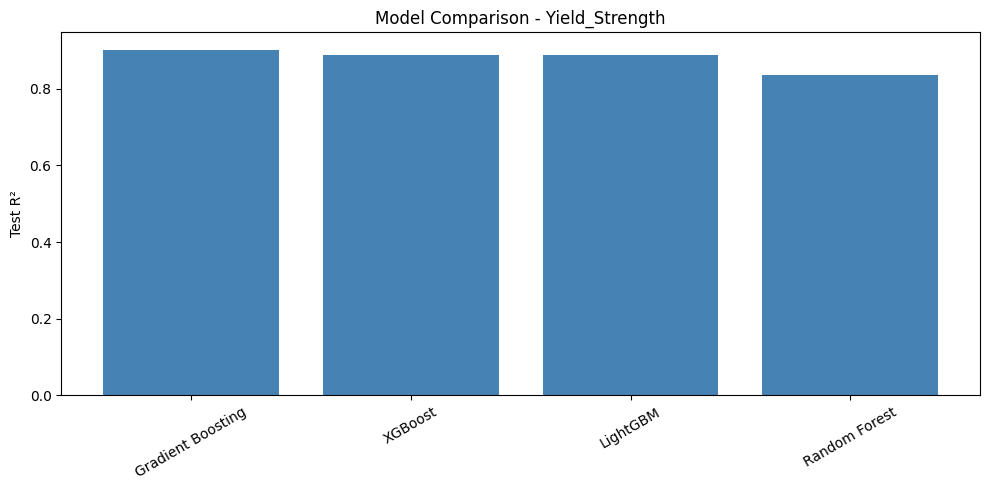

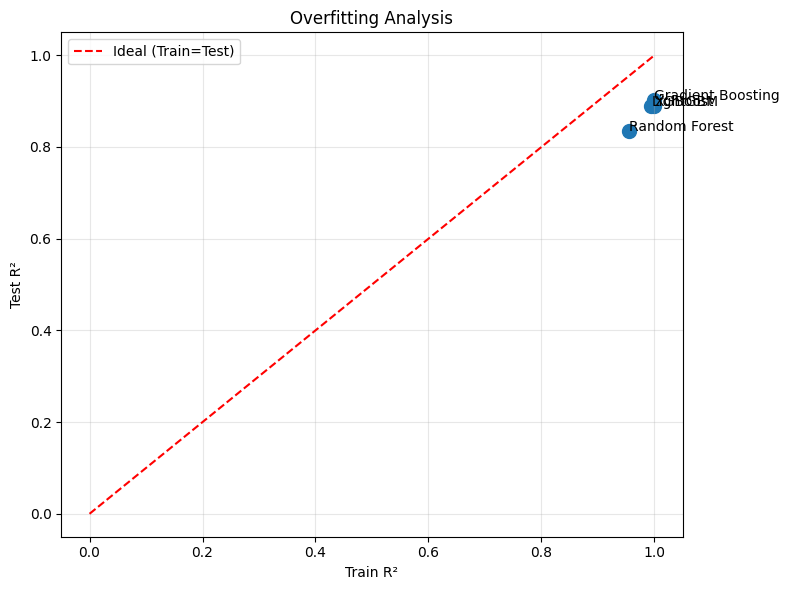

In [118]:
results_df, predictions= compare_models(X_train_all_features, X_test_all_features, y_train_without_nan, y_test_without_nan, target_name='Yield_Strength')

In [119]:
interpret_results(results_df, 'yield_strength_mpa')

Results Interpretation - Gradient Boosting
R² (Test): 0.9021
RMSE: 31.23
MAE: 16.79
MAPE: 3.06%
Cross-Validation R²: 0.8938 ± 0.0195
Overfitting (Train-Test): 0.0975
 Very good prediction accuracy.


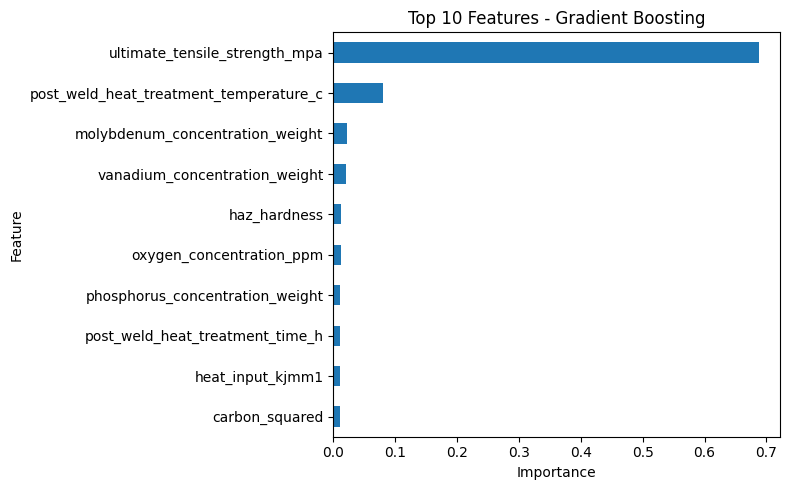

In [120]:
plot_top_features(results_df, X_train_all_features, y_train_without_nan)

### b.Data set without post-welding measurement

In [121]:
# Post-weld measurement columns to be removed
post_weld_measurement= [
    "ultimate_tensile_strength_mpa",
    "elongation_percent",
    "reduction_of_area_percent",
    "charpy_temperature_c",
    "charpy_impact_toughness_j",
    "haz_hardness"
]

# Remove these columns from the training and test set 
X_train_pre_and_during_weld = X_train_all_features.drop(
    columns=[c for c in post_weld_measurement if c in X_train_all_features]
)

X_test_pre_and_during_weld = X_test_all_features.drop(
    columns=[c for c in post_weld_measurement if c in X_test_all_features.columns]
)

print(X_train_pre_and_during_weld.shape, X_test_pre_and_during_weld.shape)

(613, 42) (167, 42)


Model Comparison - Yield_Strength

 Training XGBoost... R² = 0.8519 | RMSE = 38.40

 Training LightGBM... R² = 0.8386 | RMSE = 40.09

 Training Random Forest... R² = 0.7428 | RMSE = 50.61

 Training Gradient Boosting... R² = 0.8566 | RMSE = 37.79

Results Summary (sorted by Test R²):
               Model   Test_R2  Test_RMSE   Test_MAE  CV_R2_mean  Overfitting
0  Gradient Boosting  0.856632  37.786552  22.712737    0.820855     0.138314
1            XGBoost  0.851906  38.404394  23.527456    0.823106     0.144406
2           LightGBM  0.838626  40.089294  23.980072    0.794831     0.138427
3      Random Forest  0.742807  50.610522  33.643579    0.708900     0.162564


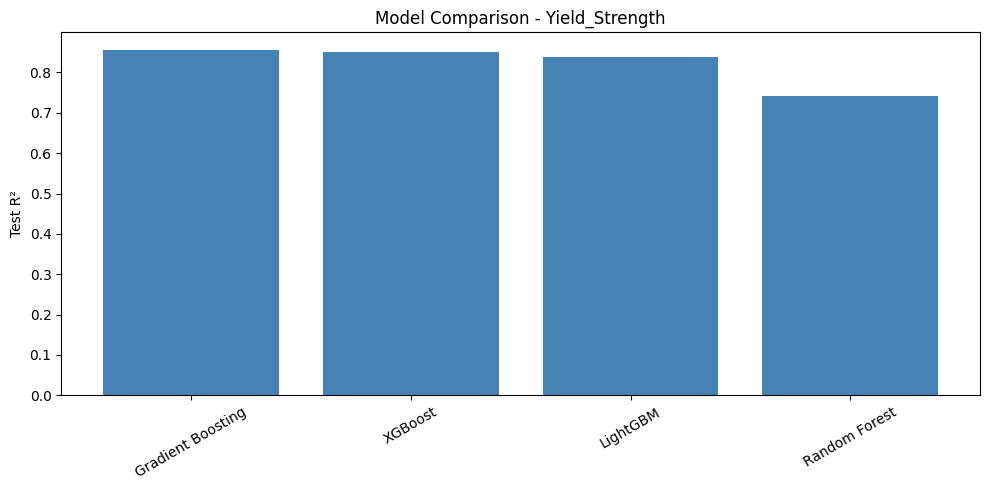

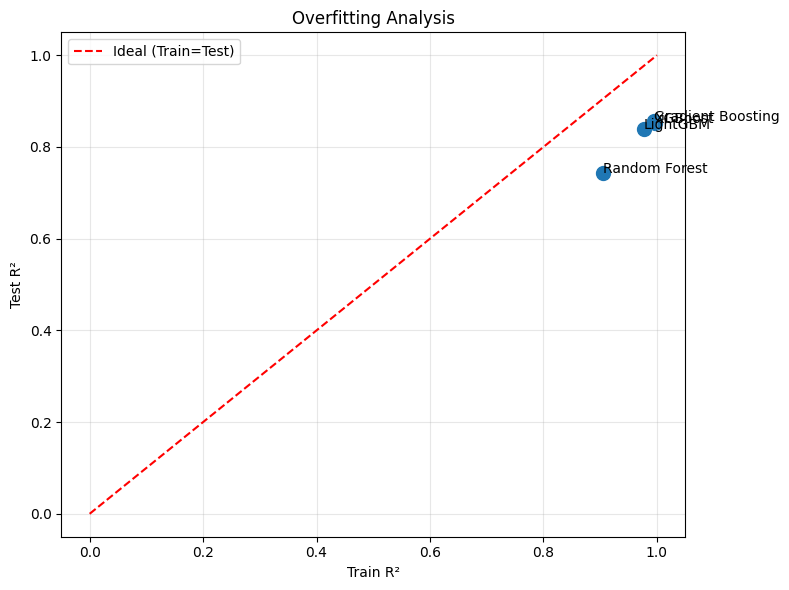

In [122]:
results_df, predictions= compare_models(X_train_pre_and_during_weld, X_test_pre_and_during_weld, y_train_without_nan, y_test_without_nan, target_name='Yield_Strength')

In [123]:
interpret_results(results_df, 'yield_strength_mpa')

Results Interpretation - Gradient Boosting
R² (Test): 0.8566
RMSE: 37.79
MAE: 22.71
MAPE: 4.20%
Cross-Validation R²: 0.8209 ± 0.0511
Overfitting (Train-Test): 0.1383
 The model may be overfitting.


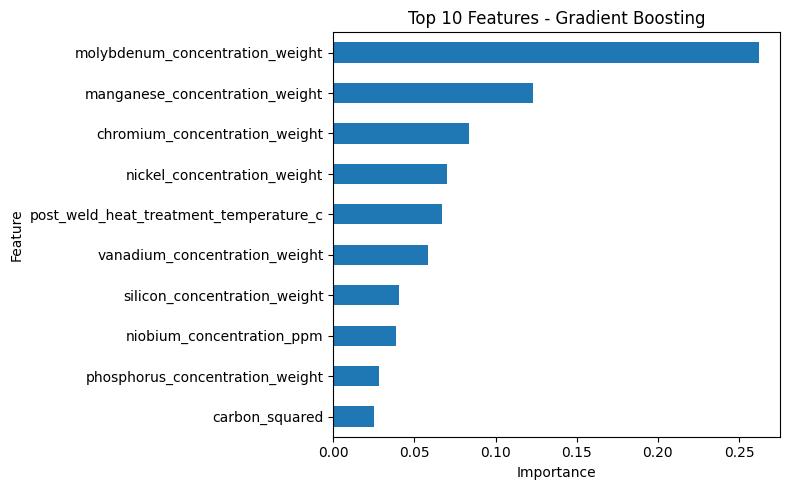

In [124]:
plot_top_features(results_df, X_train_pre_and_during_weld, y_train_without_nan)

 ## 5. Conclusion

#### Best model with all available features :

Using all features, including post-weld measurements, the Gradient Boosting model performs best:

- Test R²: ~0.90  
- Test RMSE: ~31 MPa  

Including post-weld measurements introduces data leakage, since these measurements are not available during the welding process. This artificially boosts model performance.

#### Best model based on pre- and during-weld features :

Using only variables available before and during welding (chemical composition + welding parameters), the Gradient Boosting model also performs best:

- Test R² ≈ 0.857  
- RMSE ≈ 38 MPa  

It has slightly lower performance than using all features, but the model is realistically deployable.

For this model, the variables which have the highest impact on final yield strength and can guide process optimization are: 

- Molybdenum concentration weight  
- Manganese concentration weight  
- Chromium concentration weight  
- Nickel concentration weight  
- Post-weld heat treatment temperature
